In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

## Control design for a 1DoF mass-spring-damper system

The following example is a control design task for a mass-spring-damper system, a typical second-order model. The structure consists of a sliding mass (friction is ignored), connected to a reference point with an infinitely expandable string-damper pair.<br><br>
<img src="Images/mbk.png" width="40%" />
<br>

Its equation of motion can be stated as:
<br>
$$m\cdot\ddot{x}+b\cdot\dot{x}+k\cdot{x}=F$$
<br>
After the Laplace transformation of the differential equation, the transfer function can be expressed as:
<br>
$$G(s)=\frac{1}{m\cdot s^2 +b\cdot s + k}$$
<br>
Your task is to choose a controller type, and tune it to acceptable levels of performance!

<b>First, choose a system model!</b><br>
Toggle between different realistic models with randomly preselected values (buttons *Model 1* - *Model 6*). By clicking the *Preset* button default, valid predetermined controller parameters are set and cannot be tuned further.

<IPython.core.display.Javascript object>


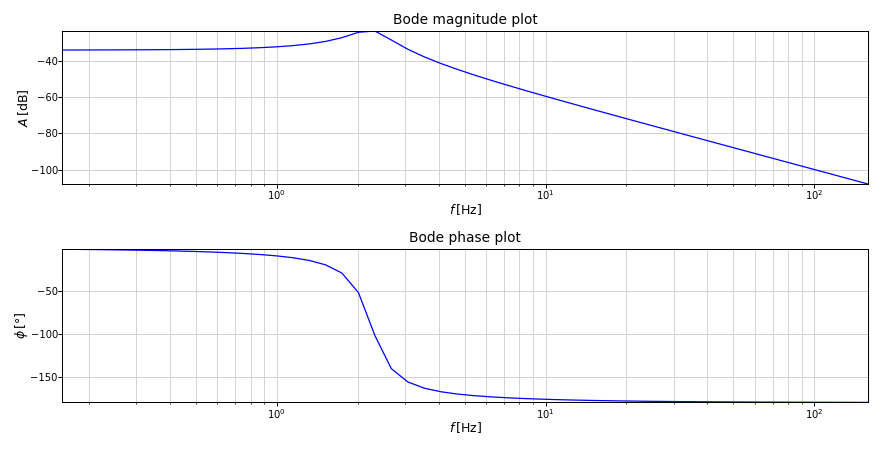

ToggleButtons(description='System: ', index=6, layout=Layout(width='60%'), options=(('Model 1', 0), ('Model 2'…

Output()

Output()

In [2]:
# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

f1_line1, = f1_ax1.plot([], [])
f1_line2, = f1_ax2.plot([], [])  

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='both', tight=True)
f1_ax2.autoscale(enable=True, axis='both', tight=True)

f1_ax1.set_title('Bode magnitude plot', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Bode phase plot', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

# System parameters

def build_base_model(m, k, b):
    
    W_sys = c.tf([1], [m, b, k])
    
    print('System transfer function:')
    print(W_sys)
    
    # System analysis
    
    poles = c.pole(W_sys)     # Poles
    
    print('System poles:\n')
    print(poles)
    
    global f1_line1, f1_line2
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)
    
    mag, phase, omega = c.bode_plot(W_sys, Plot=False)   # Bode-plot
    
    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   
    
    f1_ax1.relim()
    f1_ax2.relim()
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
# GUI widgets

typeSelect = w.ToggleButtons(
    options=[('Model 1', 0), ('Model 2', 1), ('Model 3', 2), ('Model 4', 3), ('Model 5', 4), ('Model 6', 5), ('Preset', -1)],
    value =-1, description='System: ', layout=w.Layout(width='60%'))

m_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description='m [kg] :', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
k_slider = w.FloatLogSlider(value=100, base=10, min=-2, max=4, description='k [N/m] :', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
b_slider = w.FloatLogSlider(value=50, base=10, min=-2, max=4, description='b [Ns/m] :', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))

input_data = w.interactive_output(build_base_model, {'m':m_slider, 'k':k_slider, 'b':b_slider})

def update_sliders(index):
    global m_slider, k_slider, b_slider
    
    mval = [0.05, 0.1, 0.25, 0.5, 1, 5, 0.25]
    kval = [1.25, 10, 100, 10, 50, 1000, 50]
    bval = [1, 0.5, 2, 10, 10, 20, 1]
    
    m_slider.value = mval[index]
    k_slider.value = kval[index]
    b_slider.value = bval[index]
    
    if index == -1:
        m_slider.disabled = True
        k_slider.disabled = True
        b_slider.disabled = True
    else:
        m_slider.disabled = False
        k_slider.disabled = False
        b_slider.disabled = False
    
input_data2 = w.interactive_output(update_sliders, {'index':typeSelect})

display(typeSelect, input_data2)
display(w.HBox([m_slider, k_slider, b_slider]), input_data)

Depending on your selection, the system is either under- or overdamped.
<br>
<b>Select an appropriate controller configuration! Which one is the best for your system? Why?<br>
Set up your controller for the fastest settling time with at most 25% overshoot!</b>

You can turn on/off each of the I and D components, and if D is active, you can apply the first-order filter as well, based on the derivating time constant.

<IPython.core.display.Javascript object>


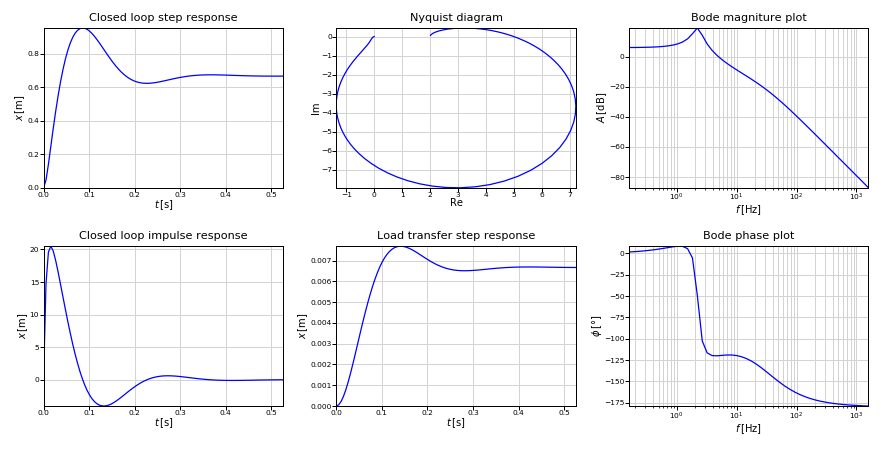

Output()

In [3]:
# PID position control

fig2, ((f2_ax1, f2_ax2, f2_ax3), (f2_ax4, f2_ax5, f2_ax6)) = plt.subplots(2, 3)
fig2.set_size_inches((9.8, 5))
fig2.set_tight_layout(True)

f2_line1, = f2_ax1.plot([], [])
f2_line2, = f2_ax2.plot([], []) 
f2_line3, = f2_ax3.plot([], [])
f2_line4, = f2_ax4.plot([], [])  
f2_line5, = f2_ax5.plot([], [])
f2_line6, = f2_ax6.plot([], [])

f2_ax1.grid(which='both', axis='both', color='lightgray')
f2_ax2.grid(which='both', axis='both', color='lightgray')
f2_ax3.grid(which='both', axis='both', color='lightgray')
f2_ax4.grid(which='both', axis='both', color='lightgray')
f2_ax5.grid(which='both', axis='both', color='lightgray')
f2_ax6.grid(which='both', axis='both', color='lightgray')

f2_ax1.autoscale(enable=True, axis='both', tight=True)
f2_ax2.autoscale(enable=True, axis='both', tight=True)
f2_ax3.autoscale(enable=True, axis='both', tight=True)
f2_ax4.autoscale(enable=True, axis='both', tight=True)
f2_ax5.autoscale(enable=True, axis='both', tight=True)
f2_ax6.autoscale(enable=True, axis='both', tight=True)


f2_ax1.set_title('Closed loop step response', fontsize=9)
f2_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax1.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax1.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax2.set_title('Nyquist diagram', fontsize=9)
f2_ax2.set_xlabel(r'Re', labelpad=0, fontsize=8)
f2_ax2.set_ylabel(r'Im', labelpad=0, fontsize=8)
f2_ax2.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax3.set_title('Bode magniture plot', fontsize=9)
f2_ax3.set_xscale('log')
f2_ax3.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax3.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=8)
f2_ax3.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax4.set_title('Closed loop impulse response', fontsize=9)
f2_ax4.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax4.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax4.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax5.set_title('Load transfer step response', fontsize=9)
f2_ax5.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax5.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax5.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax6.set_title('Bode phase plot', fontsize=9)
f2_ax6.set_xscale('log')
f2_ax6.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax6.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=8)
f2_ax6.tick_params(axis='both', which='both', pad=0, labelsize=6)

def position_control(Kp, Ti, Td, Fd, Ti0, Td0, Fd0, m, k, b):
    
    W_sys = c.tf([1], [m, b, k])
    
    # PID Controller
    
    P = Kp             # Proportional term
    I = Kp / Ti        # Integral term
    D = Kp * Td        # Derivative term
    Td_f = Td / Fd     # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))  # PID controller in time constant format
    
    W_open = c.series(W_PID, W_sys)         # Open loop with two integrators added for position output
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
    
    W_load = c.feedback(W_sys, W_PID, -1)   # Transfer function of the load based errors  
                        
    # Display
                        
    global f2_line1, f2_line2, f2_line3, f2_line4, f2_line5, f2_line6
    
    f2_ax1.lines.remove(f2_line1)
    f2_ax2.lines.remove(f2_line2)
    f2_ax3.lines.remove(f2_line3)
    f2_ax4.lines.remove(f2_line4)
    f2_ax5.lines.remove(f2_line5)
    f2_ax6.lines.remove(f2_line6)
    
    tout, yout = c.step_response(W_closed)
    f2_line1, = f2_ax1.plot(tout, yout, lw=1, color='blue') 
    
    _, _, ob = c.nyquist_plot(W_open, Plot=False)   # Small resolution plot to determine bounds        
    real, imag, freq = c.nyquist_plot(W_open, omega=np.logspace(np.log10(ob[0]), np.log10(ob[-1]), 1000), Plot=False)
    f2_line2, = f2_ax2.plot(real, imag, lw=1, color='blue')
    
    mag, phase, omega = c.bode_plot(W_open, Plot=False)
    f2_line3, = f2_ax3.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f2_line6, = f2_ax6.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')

    tout, yout = c.impulse_response(W_closed)
    f2_line4, = f2_ax4.plot(tout, yout, lw=1, color='blue')   

    tout, yout = c.step_response(W_load)
    f2_line5, = f2_ax5.plot(tout, yout, lw=1, color='blue')
    
    f2_ax1.relim()
    f2_ax2.relim()
    f2_ax3.relim()
    f2_ax4.relim()
    f2_ax5.relim()
    f2_ax6.relim()
    f2_ax1.autoscale_view()
    f2_ax2.autoscale_view()
    f2_ax3.autoscale_view()
    f2_ax4.autoscale_view()
    f2_ax5.autoscale_view()
    f2_ax6.autoscale_view()
    
def update_controller(index):
    global Kp_slider, Ti_slider, Td_slider, Fd_slider, Ti_button, Td_button, Fd_button
    
    if index == -1:
        Kp_slider.value = 100
        Td_slider.value = 0.05
        Fd_slider.value = 10
        Ti_button.value = False
        Td_button.value = True
        Fd_button.value = True
        
        Kp_slider.disabled = True
        Ti_slider.disabled = True
        Td_slider.disabled = True
        Fd_slider.disabled = True
        Ti_button.disabled = True
        Td_button.disabled = True
        Fd_button.disabled = True
    else:
        Kp_slider.disabled = False
        Ti_slider.disabled = False
        Td_slider.disabled = False
        Fd_slider.disabled = False
        Ti_button.disabled = False
        Td_button.disabled = False
        Fd_button.disabled = False
    
# GUI widgets

Kp_slider = w.FloatLogSlider(value=0.5, base=10, min=-1, max=4, description='Kp:', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Ti_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Td_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Fd_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))

Ti_button = w.ToggleButton(value=True, description='Ti',
                           layout=w.Layout(width='auto', flex='1 1 0%'))
Td_button = w.ToggleButton(value=False, description='Td',
                           layout=w.Layout(width='auto', flex='1 1 0%'))
Fd_button = w.ToggleButton(value=False, description='Fd',
                           layout=w.Layout(width='auto', flex='1 1 0%'))

input_data = w.interactive_output(position_control, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                                 'Fd': Fd_slider, 'Ti0' : Ti_button, 'Td0': Td_button,
                                                 'Fd0': Fd_button, 'm':m_slider, 'k':k_slider, 'b':b_slider})

w.interactive_output(update_controller, {'index': typeSelect})

display(w.HBox([Kp_slider, Ti_button, Ti_slider, Td_button, Td_slider, Fd_button, Fd_slider]), input_data)

In the following simulation, you can observe the movement of your system based on your controller setup. You can create reference signals and even apply some disturbance and see how the system reacts.

<b>Is your configuration suitable for signal-following? Readjust your controller so that it can follow a sine wave acceptably!</b>
<br><br>
<i>(The animations are scaled to fit the frame through the whole simulation. Because of this, unstable solutions might not seem to move until the very last second.)</i>

<IPython.core.display.Javascript object>


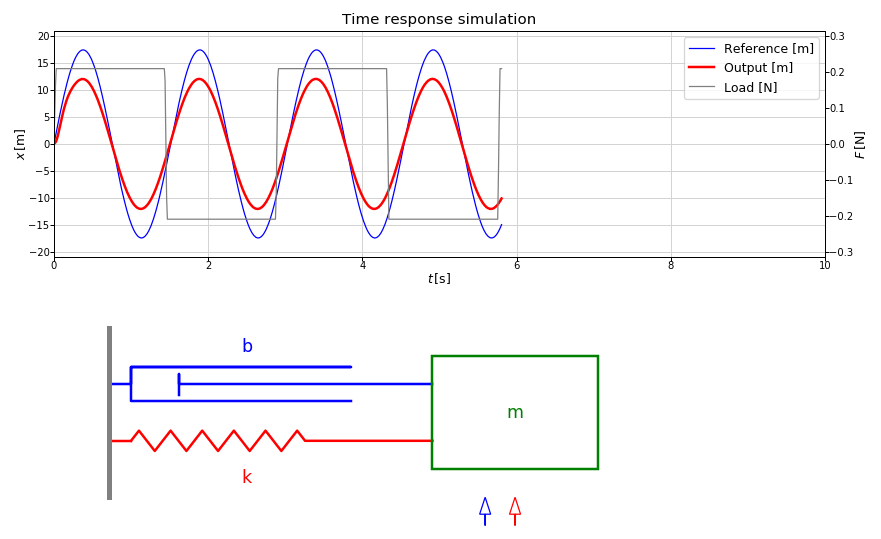

Output()

In [4]:
# Simulation data

anim_fig = plt.figure()
anim_fig.set_size_inches((9.8, 6))
anim_fig.set_tight_layout(True)

anim_ax1 = anim_fig.add_subplot(211)
anim_ax2 = anim_ax1.twinx()

frame_count=1000

l1 = anim_ax1.plot([], [], lw=1, color='blue')
l2 = anim_ax1.plot([], [], lw=2, color='red')
l3 = anim_ax2.plot([], [], lw=1, color='grey')

line1 = l1[0]
line2 = l2[0]
line3 = l3[0]

anim_ax1.legend(l1+l2+l3, ['Reference [m]', 'Output [m]', 'Load [N]'], loc=1)

anim_ax1.set_title('Time response simulation', fontsize=12)
anim_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=10)
anim_ax1.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=10)
anim_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)
anim_ax2.set_ylabel(r'$F\/$[N]', labelpad=0, fontsize=10)
anim_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

anim_ax1.grid(which='both', axis='both', color='lightgray')

T_plot = []
X_plot = []
L_plot = []
R_plot = []

# Scene data

scene_ax = anim_fig.add_subplot(212)
scene_ax.set_xlim((-3, 4))
scene_ax.set_ylim((-0.5, 1.5))
scene_ax.axis('off')

scene_ax.plot([-2.5, -2.3, -2.3, -0.3, -2.3, -2.3, -0.3], [0.75, 0.75, 0.9, 0.9, 0.9, 0.6, 0.6], lw=2, color='blue', zorder=0)
scene_ax.plot([-2.5, -2.3], [0.25, 0.25], lw=2, color='red', zorder=0)
scene_ax.plot([-2.5, -2.5], [1.25, -0.25], lw=4, color='gray', zorder=2)

scene_ax.text(-1.3, 1, 'b', fontsize=14, color='blue', va='bottom', zorder=5)
scene_ax.text(-1.3, 0, 'k', fontsize=14, color='red', va='top', zorder=5)

b_line, = scene_ax.plot([], [], lw=2, color='blue')
k_line, = scene_ax.plot([], [], lw=2, color='red')

m_text = scene_ax.text(1.75, 0.5, 'm', fontsize=14, color='green', va='center', ha='center', zorder=5)
m_box = patches.Rectangle((1, 0), 1.5, 1, lw=2, color='green', fill=False, zorder=10)
scene_ax.add_patch(m_box)

x_arrow = scene_ax.arrow(1.75, -0.5, 0, 0.25, color='blue', head_width=0.1,
                         length_includes_head=True, lw=1, fill=False, zorder=5)
r_arrow = scene_ax.arrow(1.75, -0.5, 0, 0.25, color='red', head_width=0.1,
                         length_includes_head=True, lw=1, fill=False, zorder=5)
base_arrow = x_arrow.xy

pos_var = []
ref_var = []

#Simulation function

def simulation(Kp, Ti, Td, Fd, Ti0, Td0, Fd0, m, k, b, T, dt, X, Xf, Xa, Xo, L, Lf, La, Lo):
    
    # Controller
    P = Kp            # Proportional term
    I = Kp / Ti       # Integral term
    D = Kp * Td       # Derivative term
    Td_f = Td / Fd    # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))    # PID controller
    
    # System
    W_sys = c.tf([1], [m, b, k])
    
    # Model
    W_open = c.series(W_PID, W_sys)         # Open loop with two integrators added for position output
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
    
    W_load = c.feedback(W_sys, W_PID, -1)   # Transfer function of the load based errors  
    
    # Reference and disturbance signals

    T_sim = np.arange(0, T, dt, dtype=np.float64)
    
    if X == 0:     # Constant reference
        X_sim = np.full_like(T_sim, Xa * Xo)
    elif X == 1:   # Sine wave reference
        X_sim = (np.sin(2 * np.pi * Xf * T_sim) + Xo) * Xa
    elif X == 2:   # Square wave reference
        X_sim = (np.sign(np.sin(2 * np.pi * Xf * T_sim)) + Xo) * Xa
        
    if L == 0:     # Constant load
        L_sim = np.full_like(T_sim, La * Lo)
    elif L == 1:   # Sine wave load
        L_sim = (np.sin(2 * np.pi * Lf * T_sim) + Lo) * La
    elif L == 2:   # Square wave load
        L_sim = (np.sign(np.sin(2 * np.pi * Lf * T_sim)) + Lo) * La
    elif L_type.value == 3:   # Noise form load
        L_sim = np.interp(T_sim, np.linspace(0, T, int(T * Lf) + 2),
                          np.random.normal(loc=(Lo * La), scale=La, size=int(T * Lf) + 2))
    
    # System response
        
    Tx, youtx, xoutx = c.forced_response(W_closed, T_sim, X_sim)
    Tl, youtl, xoutl = c.forced_response(W_load, T_sim, L_sim)
    R_sim = np.nan_to_num(youtx + youtl)
    
    # Display
    
    XR_max = max(np.amax(np.absolute(np.concatenate((X_sim, R_sim)))), Xa)
    L_max = max(np.amax(np.absolute(L_sim)), La)
    
    anim_ax1.set_xlim((0, T))
    anim_ax1.set_ylim((-1.2 * XR_max, 1.2 * XR_max))
    anim_ax2.set_ylim((-1.5 * L_max, 1.5 * L_max))
    
    global T_plot, X_plot, L_plot, R_plot, pos_var, ref_var
    
    T_plot = np.linspace(0, T, frame_count, dtype=np.float32)
    X_plot = np.interp(T_plot, T_sim, X_sim)
    L_plot = np.interp(T_plot, T_sim, L_sim)
    R_plot = np.interp(T_plot, T_sim, R_sim)
    
    pos_var = R_plot/XR_max
    ref_var = X_plot/XR_max
        
def anim_init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    
    b_line.set_data([], [])
    k_line.set_data([], [])
    
    x_arrow.set_xy(base_arrow)
    r_arrow.set_xy(base_arrow)
    
    m_text.set_position((1.75, 0.5))
    m_box.set_xy((1, 0))
    
    return (line1, line2, line3, m_text, m_box, b_line, k_line,)

def animate(i):
    line1.set_data(T_plot[0:i], X_plot[0:i])
    line2.set_data(T_plot[0:i], R_plot[0:i])
    line3.set_data(T_plot[0:i], L_plot[0:i])
    
    b_line.set_data([-1.3, -1.3, -1.3, 1]+pos_var[i], [0.66, 0.84, 0.75, 0.75])
    k_line.set_data(np.append(np.array([0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22])*(pos_var[i]+2)/20-2.3, pos_var[i]+1),
                    [0.25, 0.34, 0.16, 0.34, 0.16, 0.34, 0.16, 0.34, 0.16, 0.34, 0.16, 0.34, 0.25, 0.25])
    
    x_arrow.set_xy(base_arrow+[ref_var[i], 0])
    r_arrow.set_xy(base_arrow+[pos_var[i], 0])
    
    m_text.set_position((pos_var[i]+1.75, 0.5))
    m_box.set_x(pos_var[i]+1)
    
    return (line1, line2, line3, m_text, m_box, b_line, k_line,)

anim = animation.FuncAnimation(anim_fig, animate, init_func=anim_init,
                               frames=frame_count, interval=10, blit=True,
                               repeat=True)

# Controllers

T_slider = w.FloatLogSlider(value=10, base=10, min=-0.7, max=1, step=0.01,
                            description='Duration [s]:', continuous_update=False,
                            orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))

dt_slider = w.FloatLogSlider(value=0.1, base=10, min=-3, max=-1, step=0.01,
                             description='Timestep [s]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
       
X_type = w.Dropdown(options=[('Constant', 0), ('Sine', 1), ('Square', 2)], value=1,
                     description='Reference: ', continuous_update=False, layout=w.Layout(width='auto', flex='3 3 auto'))    
Xf_slider = w.FloatLogSlider(value=0.5, base=10, min=-2, max=2, step=0.01,
                             description='Frequency [Hz]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Xa_slider = w.FloatLogSlider(value=1, base=10, min=-2, max=2, step=0.01,
                             description='Amplitude [m]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Xo_slider = w.FloatSlider(value=0, min=-10, max=10, description='Offset/Ampl:', continuous_update=False,
                              orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))    
    
L_type = w.Dropdown(options=[('Constant', 0), ('Sine', 1), ('Square', 2), ('Noise', 3)], value=2,
                     description='Load: ', continuous_update=False, layout=w.Layout(width='auto', flex='3 3 auto'))    
Lf_slider = w.FloatLogSlider(value=1, base=10, min=-2, max=2, step=0.01,
                             description='Frequency [Hz]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
La_slider = w.FloatLogSlider(value=0.1, base=10, min=-2, max=2, step=0.01,
                             description='Amplitude [N]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Lo_slider = w.FloatSlider(value=0, min=-10, max=10, description='Offset/Ampl:', continuous_update=False,
                              orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))

input_data = w.interactive_output(simulation, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                               'Fd': Fd_slider, 'Ti0' : Ti_button, 'Td0': Td_button,
                                               'Fd0': Fd_button,
                                               'm':m_slider, 'k':k_slider, 'b':b_slider,
                                               'T': T_slider, 'dt': dt_slider,
                                               'X': X_type, 'Xf': Xf_slider, 'Xa': Xa_slider, 'Xo': Xo_slider,
                                               'L': L_type, 'Lf': Lf_slider, 'La': La_slider, 'Lo': Lo_slider})

display(w.HBox([w.HBox([T_slider, dt_slider], layout=w.Layout(width='25%')),
                w.Box([], layout=w.Layout(width='5%')),
                w.VBox([X_type, w.HBox([Xf_slider, Xa_slider, Xo_slider])], layout=w.Layout(width='30%')),
                w.Box([], layout=w.Layout(width='5%')),
                w.VBox([L_type, w.HBox([Lf_slider, La_slider, Lo_slider])], layout=w.Layout(width='30%'))],
                layout=w.Layout(width='100%', justify_content='center')), input_data)


The duration parameter controls the simulated timeframe and does not affect the runtime of the animation. In contrast, the timestep controls the model sampling and can refine the results in exchange for higher computational resources.